### Investigating sky levels in DESI Commissioning Data

In [1]:
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
import os
import sys
import json
import glob
import collections

import matplotlib as mpl

from pathlib import Path
from scipy import ndimage
from astropy.stats import sigma_clip

In [4]:
assert os.getenv('NERSC_HOST', False)

In [5]:
# Path to raw files
ROOT = Path('/project/projectdirs/desi/spectro/data/')
assert ROOT.exists()

#### Background info on GFAs (Guide Focus Alignment array):

- https://desi.lbl.gov/DocDB/cgi-bin/private/RetrieveFile?docid=1786;filename=2016%20FPS%20FDR%20GFA%20System.pdf;version=1
- https://desi.lbl.gov/DocDB/cgi-bin/private/RetrieveFile?docid=5315;filename=DESI-5315-v2.pdf;version=2

For a short tutorial on how to access and process raw GFA data, see D. Kirkby's notebook:

https://github.com/desihub/desicmx/blob/master/analysis/gfa/GFA-ETC-Pipeline.ipynb

http://web.replicator.dev-cattle.stable.spin.nersc.org:60040/TV3/app/T/index?namespace=telemetry

Install `desietcimg` if you haven't already:

In [6]:
try:
    import desietcimg
    print('desietcimg already installed')
except ImportError:
    print('Installing desietcimg...')
    !{sys.executable} -m pip install --user git+https://github.com/dkirkby/desietcimg

desietcimg already installed


Upgrade if necessary (note that you need to restart notebook if upgrading):

In [7]:
upgrade = False

In [8]:
if upgrade:
    print('Upgrading desietcimg...')
    !{sys.executable} -m pip install --upgrade --user git+https://github.com/dkirkby/desietcimg

In [9]:
import desietcimg.db

from desietcimg.util import load_raw, downsample
from desietcimg.plot import plot_pixels, plot_data
from desietcimg.gfa import GFACamera

List of gfa and spec exposures taken on `20191111` taken at various moon separation angles:

See email from Julien titled `[desi-commiss 2821] moon flats`. Night summary can be found here: http://desi-www.kpno.noao.edu:8090/nightsum/nightsum-2019-11-12/nightsum.html

In [10]:
gfa_exp = [27337, 27338, 27340, 27341, 27342, 27343, 27344, 27346, 27347, 27348, 27349, 27350, 
           27352, 27353, 273524, 27355, 27356, 27358, 27359, 27360, 27361, 27362, 27364, 27365, 
           27366, 27367, 27368, 27369, 27371, 27372, 27373, 27374, 27376, 27377, 27378, 27379, 
           27380, 27382, 27383, 27384, 27385, 27386, 27388, 27389, 27390, 27391, 27392, 27394, 
           27395, 27396]

spec_exp = [27339, 27345, 27351, 27357, 27363, 27370, 27375, 27381, 27387, 27393]

Get exposure metadata:

In [11]:
if not os.path.exists('db.yaml'):
    import getpass
    pw = getpass.getpass(prompt='Enter database password: ')
    with open('db.yaml', 'w') as f:
        print('host: db.replicator.dev-cattle.stable.spin.nersc.org', file=f)
        print('dbname: desi_dev', file=f)
        print('port: 60042', file=f)
        print('user: desi_reader', file=f)
        print(f'password: {pw}', file=f)
    print('Created db.yaml')

In [12]:
db = desietcimg.db.DB()

allexps = db.query("select id,night,exptime from exposure order by id asc").dropna()
nights = allexps['night'].unique().astype(int)
print(f'DESI has observed {len(nights)} nights from {nights[0]} - {nights[-1]}')

DESI has observed 168 nights from 20190130 - 20191211


In [13]:
ExpInfo = desietcimg.db.Exposures(db)
', '.join(sorted(ExpInfo.columns))

'aborted, action, adc, airmass, aos, built, cal_lamps, collected, computer, data_location, date_obs, decoffset, deltadec, deltara, digitized, digitizing, discard, distributed, dome, domeaz, dominpos, done, errors, etc, excluded, exposed, exposing, exptime, fiberassign, flavor, focstime, focus, focus_cameras, frames, guide_cameras, guider, guider_mode, guidoffd, guidoffr, guidtime, hexapod, hexapod_time, id, image_cameras, inctrl, inpos, inposition, instance, lead, manifest, mjd_obs, mntoffd, mntoffr, moonangl, moondec, moonra, mountaz, mountel, mountha, multiframe, night, ntargets, object, observers, obstype, parallactic, paused, petals, pmready, positer, positioned, prepared, program, propid, raoffset, readout_time, reqaz, reqdec, reqel, reqha, reqra, reqtime, s2n, saved, saved_updated, script, se_annex, seeing, seqid, seqnum, seqtot, sequence, skydec, skylevel, skyra, skytime, slew_time, slewangl, spectrographs, st, started, targtdec, targtra, tcsmjd, telescope, telstat, thumbnail, t

In [14]:
def process_darks(night, first, last):
    darks = {}
    files = desietcimg.util.find_files(
        ROOT / str(night) / '{N}/gfa-{N}.fits.fz', min=first, max=last,
        partial_match_is_error=False)
    nexp = len(files)
    print('Processing {0} exposures from {1}...'.format(nexp, night))
    GFA = desietcimg.gfa.GFACamera(calib_name=str(CALIB))
    ngfa = len(GFA.gfa_names)
    mjd = np.empty((ngfa, nexp))
    temp = np.empty((ngfa, nexp))
    sigmed = np.empty((ngfa, nexp))
    data = np.empty((ngfa, nexp, 1032, 2048))
    for k, gfa in enumerate(GFA.gfa_names):
        raw, meta = desietcimg.util.load_raw(files, 'EXPTIME', 'MJD-OBS', 'GCCDTEMP', hdu=gfa)
        # Check that all exposures have the same length.
        texp = meta['EXPTIME'][0]
        assert np.all(meta['EXPTIME'] == texp)
        if k == 0:
            print('Exposure time is {0:.1f}s'.format(texp))
        # Save this camera's timestamps and temperatures.
        mjd[k] = meta['MJD-OBS']
        temp[k] = meta['GCCDTEMP']
        # Calculate and save this camera's median signal in elec/s in each exposure.
        GFA.setraw(raw, name=gfa)
        GFA.data -= GFA.get_dark_current(temp[k], texp)
        sigmed[k] = np.median(GFA.data / texp, axis=(1, 2))
        data[k] = GFA.data
    if first in darks:
        print('Replacing previous results')
    darks[first] = dict(
        night=night, last=last, nexp=nexp, texp=texp,
        mjd=mjd, temp=temp, sigmed=sigmed, data=data)
    return(darks)

In [15]:
CALIB = Path('/global/project/projectdirs/desi/cmx/gfa/calib/GFA_calib.fits')
assert CALIB.exists()

In [16]:
GFA = GFACamera(calib_name=str(CALIB))

There are 10 GFAs. 4 are used for focusing and 6 are used for guiding (see map [here] (https://desi.lbl.gov/trac/wiki/FPS/PetalMap)):

In [17]:
GFA.gfa_names

['GUIDE0',
 'FOCUS1',
 'GUIDE2',
 'GUIDE3',
 'FOCUS4',
 'GUIDE5',
 'FOCUS6',
 'GUIDE7',
 'GUIDE8',
 'FOCUS9']

Correct for bias, gain and dark current for a set of exposures on n consecutive nights (first, last):

In [18]:
night = 20191112
gfa_calib = process_darks(night, 27337, 27338)

Processing 2 exposures from 20191112...
Exposure time is 60.0s


`process_darks` returns data array with shape = (n_gfas, n_exposures, y (rows), x (columns))

In [19]:
gfa_calib[27337]['data'].shape

(10, 2, 1032, 2048)

In [20]:
gfa = 0
camera = GFA.gfa_names[gfa]
dat = gfa_calib[27337]['data'][gfa,0]

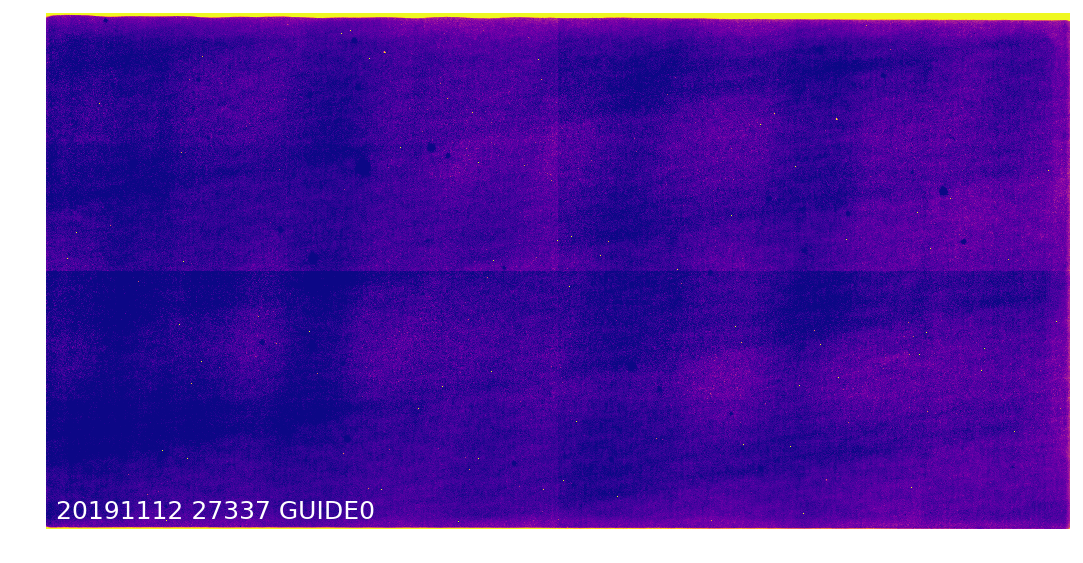

In [21]:
downsampled = downsample(dat, 2)
vmin, vmax = np.percentile(downsampled, (1, 90))
label = f'{night} 27337 {camera}'
plot_pixels(downsampled, label=label, imshow_args=dict(vmin=vmin, vmax=vmax));

Something not right with dark current correction because still seeing waffle pattern...

#### Plot sky level across the focal plane

To get spectra we want to use the calibrated outputs from nightwatch:

In [22]:
# Nightwatch files
NW_ROOT = Path('/project/projectdirs/desi/spectro/nightwatch/kpno/')
assert NW_ROOT.exists()

In [23]:
def load_flux(night, exp, band):
    
    'Load flux and metadata (in this case spectrograph #)'
    
    flux, meta = desietcimg.util.load_raw(glob.glob(str(NW_ROOT / '{}/000{}/qframe-{}*-000*.fits'.format(str(night), str(exp), band))), 'SPECGRPH', hdu=0)
    
    return(flux, meta)


def load_fibermap(night, exp, band):
    
    'Load fibermap for x,y positions on FP'
    
    fm = desietcimg.util.load_raw(glob.glob(str(NW_ROOT / '{}/000{}/qframe-{}*-000*.fits'.format(str(night), str(exp), band))), hdu=5, slices=np.arange(500))[0]
    
    return(fm)

In [24]:
def plot_mean_flux(night, exp, pa, band='r'):
    
    flux, specgrph = load_flux(night, exp, band)
    fm = load_fibermap(night, exp, band)
    
    vmin, vmax = np.percentile(flux, (1,99))
    
    spec_to_petal = {0:0, 1:0, 2:0, 3:0, 4:0, 5:0, 6:0, 7:0, 8:0, 9:0}
    
    ## Awkward ordering of petals ... should be consistent with spectrograph number as of Dec 12
    for i, spec in enumerate(specgrph['SPECGRPH']):
        if spec == 0:
            spec_to_petal[spec] = 4
        elif spec == 1:
            spec_to_petal[spec] = 8
        elif spec == 2:
            spec_to_petal[spec] = 9
        elif spec == 3:
            spec_to_petal[spec] = 0
        elif spec == 4:
            spec_to_petal[spec] = 2
        elif spec == 5:
            spec_to_petal[spec] = 3
        elif spec == 6:
            spec_to_petal[spec] = 6
        elif spec == 7:
            spec_to_petal[spec] = 7
        elif spec == 8:
            spec_to_petal[spec] = 5
        elif spec == 9:
            spec_to_petal[spec] = 1
        
    base = (400, 200)
    tip = (100 * np.cos((270 - pa) * np.pi / 180), 100 * np.sin((270 - pa) * np.pi / 180))
    
    plt.figure(figsize=(15,8))
    for i, nspec in enumerate(specgrph['SPECGRPH']):
        plt.scatter(fm[i]['FIBERASSIGN_X'], fm[i]['FIBERASSIGN_Y'], vmin=vmin, vmax=vmax, c=np.mean(flux[i], axis=(1)))
        plt.text(np.mean(fm[i]['FIBERASSIGN_X']), np.mean(fm[i]['FIBERASSIGN_Y']), 'Petal {}'.format(spec_to_petal[nspec]), fontsize=16)
    plt.arrow(base[0], base[1], 0, tip[1]+50, head_width=25, head_length=25)
    plt.arrow(base[0], base[1], tip[0], tip[1], head_width=25, head_length=25)
    plt.annotate('Moon', (base[0] + tip[0] + 40, base[1] + tip[1] + 65), fontsize=14)
    plt.annotate('N', (base[0] - 10, base[1] + tip[1] + 90), fontsize=14)
    plt.title('{} camera, night = {}, exposure = {}'.format(band, night, exp), fontsize=16)
    plt.colorbar()
    plt.axis('equal')
    plt.show()

In [25]:
import astropy.coordinates
import astropy.units as u

from astropy.time import Time

Calculate position angle between pointing and moon:

In [26]:
mjd = desietcimg.db.Exposures(db, 'mjd_obs')
sky_ra = desietcimg.db.Exposures(db, 'skyra') # boresight
sky_dec = desietcimg.db.Exposures(db, 'skydec') # boresight

In [27]:
## Unable to access exposure database to get metadata so using gfa exposure taken immediately before:
exp = 27338

In [28]:
time = Time(mjd(exp), format='mjd')
ra = sky_ra(exp)[0] * u.deg
dec = sky_dec(exp)[0] * u.deg

# KPNO Location:
height = 2067 * u.m
lon = astropy.coordinates.Longitude(angle=-111.598169, unit=u.deg)
lat = astropy.coordinates.Latitude(angle=31.9600784, unit=u.deg)
loc = astropy.coordinates.EarthLocation(lon=lon.to('rad'), lat=lat, height=height)

pointing = astropy.coordinates.SkyCoord(ra=ra, dec=dec, distance=1 * u.Gpc, frame='icrs')
moon = astropy.coordinates.get_moon(time)
moon_tgt = pointing.separation(moon)

pos_angle = pointing.position_angle(moon).to(u.deg).value[0]

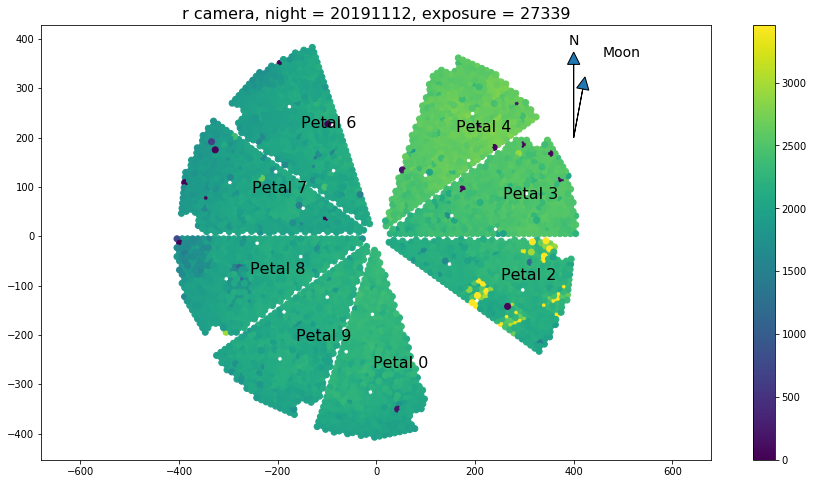

In [29]:
plot_mean_flux(night, 27339, pos_angle, band='r')